In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
data = pd.read_csv('C:\\Users\\ksn\\archive\\rating_complete.csv')
data_100000 = data[-100000:]
print(len(data))
data.head(2)

57633278


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5


In [3]:
data_mal = pd.read_csv('C:\\Users\\ksn\\archive\\anime.csv')
data_mal.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [4]:
data_train = data
me = pd.read_csv('400000.csv')

In [5]:
genres = []

for i in range(len(data_mal)):
    genres.extend(data_mal.iloc[i]['Genres'].split(', '))

colms = list(set(genres))

data_genres = pd.DataFrame(columns=colms)
data_genres['anime_id'] = data_mal['MAL_ID']
data_genres = data_genres.fillna(0)

for i in range(len(data_mal)):
    list_genres = data_mal.loc[i]['Genres'].split(', ')
    for j in list_genres:
        data_genres.at[i, j] = 1
        
data_genres.head(3)

,Seinen,Harem,School,Dementia,Shoujo Ai,Adventure,Parody,Shoujo,Yaoi,Game,...,Mystery,Music,Sports,Cars,Magic,Sci-Fi,Romance,Martial Arts,Ecchi,anime_id
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,5
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,6


In [6]:
for i in range(len(data_genres)):
    try:
        data_genres.at[i, 'year'] = int(re.findall('[0-9]{4}', str(data_mal.loc[data_mal['MAL_ID'] == data_genres.iloc[i]['anime_id']]['Aired'].values[0]))[0])
    except IndexError:
        data_genres.at[i, 'year'] = 9999

In [7]:
data_genres.head(3)

,Seinen,Harem,School,Dementia,Shoujo Ai,Adventure,Parody,Shoujo,Yaoi,Game,...,Music,Sports,Cars,Magic,Sci-Fi,Romance,Martial Arts,Ecchi,anime_id,year
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1998.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,5,2001.0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,6,1998.0


### 0th level

In [8]:
my_type = data_mal.loc[data_mal['Type'] == 'TV']['MAL_ID'].values.tolist()
data_train = data_train.loc[data_train['anime_id'].isin(my_type)]
data_genres = data_genres.loc[data_genres['anime_id'].isin(my_type)]

# my_genres = data_genres.loc[(data_genres['School'] == 1)\
#                 |(data_genres['Comedy'] == 1)\
#                 |(data_genres['Music'] == 1)\
#                 |(data_genres['Parody'] == 1)\
#                 |(data_genres['Sci-Fi'] == 1)\
#                 |(data_genres['Fantasy'] == 1)\
#                 |(data_genres['Slice of Life'] == 1)]['anime_id'].values.tolist()
# data_train = data_train.loc[data_train['anime_id'].isin(my_genres)]
# data_genres = data_genres.loc[data_genres['anime_id'].isin(my_genres)]

my_year = data_genres.loc[data_genres['year'] > 2000]['anime_id'].values.tolist()
data_train = data_train.loc[data_train['anime_id'].isin(my_year)]
data_genres = data_genres.loc[data_genres['anime_id'].isin(my_year)]

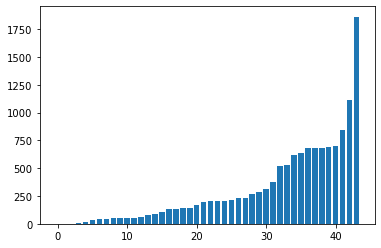

In [9]:
list_sum_col = []
for i in data_genres.columns:
    if i != 'anime_id' and i != 'year':
        list_sum_col.append(sum(data_genres[i]))
    
plt.bar([i for i in range(len(list_sum_col))], height=sorted(list_sum_col))
plt.show()

In [10]:
for i in data_genres.columns:
    if i != 'anime_id' and sum(data_genres[i]) < 200:
        data_genres.drop(i, axis=1, inplace=True)

data_genres.columns

Index(['Seinen', 'Harem', 'School', 'Adventure', 'Shoujo', 'Drama', 'Mecha',
       'Kids', 'Comedy', 'Shounen', 'Action', 'Super Power', 'Historical',
       'Slice of Life', 'Fantasy', 'Supernatural', 'Mystery', 'Sports',
       'Magic', 'Sci-Fi', 'Romance', 'Ecchi', 'anime_id', 'year'],
      dtype='object')

In [11]:
len(data_train)

36654228

### 1st level

In [12]:
popularity_anime = data_train.groupby('anime_id')['rating'].sum().reset_index().sort_values('rating', ascending=False)
popularity_anime.head(3)

,anime_id,rating
442,1535,1587860
1584,16498,1445712
902,5114,1239579


In [13]:
popularity_anime = popularity_anime.reset_index(drop=True)
popularity_anime['rating_rank'] = popularity_anime.index
popularity_anime.drop('rating', axis=1, inplace=True)
popularity_anime.head(3)

,anime_id,rating_rank
0,1535,0
1,16498,1
2,5114,2


In [14]:
data_train = pd.merge(data_train, popularity_anime, how='left', on='anime_id')

In [15]:
user_rating = data_train.groupby('user_id')['rating_rank'].sum().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_rating.head(3)

,user_id,rating_rank
0,189037,5811266
1,68042,5388804
2,162615,5270260


In [16]:
user_val = data_train.groupby('user_id')['rating_rank'].count().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_val.head(3)

,user_id,rating_rank
0,189037,3371
1,68042,3234
2,162615,3070


In [17]:
user_rating = pd.merge(user_rating, user_val, how='left', on='user_id')
user_rating['rating_rank'] = user_rating['rating_rank_x']/user_rating['rating_rank_y']
user_rating.drop(['rating_rank_x', 'rating_rank_y'], axis=1, inplace=True)
user_rating.head(3)

,user_id,rating_rank
0,189037,1723.899733
1,68042,1666.296846
2,162615,1716.697068


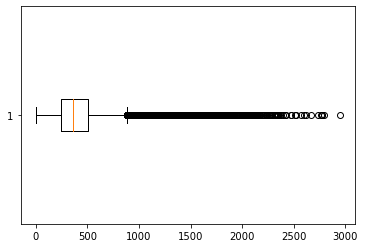

In [18]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

selected users who rated not only popular anime

In [19]:
user_rating = user_rating.loc[(user_rating['rating_rank'] < 12000) & (user_rating['rating_rank'] > 400)]
user_list = user_rating['user_id'].tolist()

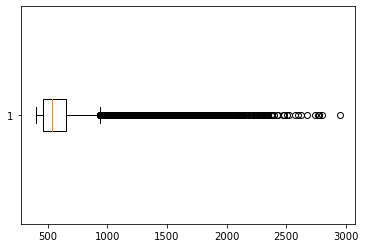

In [20]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

In [21]:
data_train = data_train.loc[data_train['user_id'].isin(user_list)]
data_train.drop('rating_rank', axis=1, inplace=True)
data_train = pd.concat([data_train, me], ignore_index=True)
len(data_train)

22947799

In [22]:
len(data_train.groupby('user_id')), len(data_train.groupby('anime_id'))

(128831, 3543)

In [23]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  


class MainRecommender:
    def __init__(self, data, weighting=True):
        self.user_item_matrix = self.prepare_matrix(data)
        self.id_to_itemid, self.userid_to_id = self.prepare_dicts(
            self.user_item_matrix)
        self.top100 = self.top_100(data)
        self.model_als = self.fit_als(self.user_item_matrix)
        self.similar_items_recommendations = self.fit_similar_items_recommendations(self.user_item_matrix)

    @staticmethod
    def top_100(data):
        popularity = data.groupby('anime_id')['rating'].sum().reset_index()
        top_100 = popularity.sort_values('rating', ascending=False).head(100).anime_id.tolist()
        return top_100

    @staticmethod
    def prepare_matrix(data):
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', columns='anime_id',
                                          values='rating',
                                          fill_value=0)
        
        user_item_matrix = user_item_matrix.astype(float)
        return user_item_matrix

    @staticmethod
    def prepare_dicts(user_item_matrix):
        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, userid_to_id

    @staticmethod
    def fit_als(user_item_matrix):
        model = AlternatingLeastSquares(factors=200,
                                        regularization=0.01,
                                        iterations=20,
                                        num_threads=0,
                                        random_state=38)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())
        return model

    @staticmethod
    def fit_similar_items_recommendations(user_item_matrix):
        similar_items_recommendations = ItemItemRecommender(K=200, num_threads=0)
        similar_items_recommendations.fit(csr_matrix(user_item_matrix).T.tocsr())
        return similar_items_recommendations
    
    def get_als_recommendations(self, user, N):
        res = [self.id_to_itemid[rec[0]] for rec in
               self.model_als.recommend(userid=self.userid_to_id[user],
                               user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                               N=N,
                               filter_already_liked_items=True,
                               recalculate_user=True)]
        return res

    def get_similar_items_recommendations(self, user, N):
        res = [self.id_to_itemid[rec[0]] for rec in
               self.similar_items_recommendations.recommend(userid=self.userid_to_id[user],
                               user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                               N=N,
                               filter_already_liked_items=True,
                               recalculate_user=True)]
        return res

In [24]:
recommender = MainRecommender(data_train)

In [25]:
list_als = recommender.get_als_recommendations(400000, N=100)
sum([data_mal.loc[data_mal['MAL_ID'] == i]['Popularity'].values for i in list_als])[0]

61511

In [26]:
list_si = recommender.get_similar_items_recommendations(400000, N=100)
sum([data_mal.loc[data_mal['MAL_ID'] == i]['Popularity'].values for i in list_si])[0]

10091

### 2nd level

In [27]:
me_genres = pd.merge(me['anime_id'], data_genres, how='left', on='anime_id').mode().loc[0][1:].values

def rec_fin(list_rec):
    list_corr = []
    list_anime_name = []
    list_url = []
    list_popularity = []

    for i in list_rec:
        list_corr.append(np.corrcoef(me_genres, data_genres.loc[data_genres['anime_id'] == i].values[0][:-1])[0, 1])
        list_anime_name.append(data_mal.loc[data_mal['MAL_ID'] == i]['Name'].values[0])
        list_url.append('https://myanimelist.net/anime/' + str(i))
        list_popularity.append(data_mal.loc[data_mal['MAL_ID'] == i]['Popularity'].values[0])
    
    return pd.DataFrame({'anime_id': list_rec, 'corr': list_corr, 'name': list_anime_name, 'url': list_url, \
                         'popularity': list_popularity}).sort_values('popularity', ascending=False).drop_duplicates().head(50)

In [28]:
rec_fin(recommender.top_100(data_train))

,anime_id,corr,name,url,popularity
99,59,0.999341,Chobits,https://myanimelist.net/anime/59,332
85,71,0.999662,Full Metal Panic!,https://myanimelist.net/anime/71,322
89,1840,0.999999,Zero no Tsukaima: Futatsuki no Kishi,https://myanimelist.net/anime/1840,319
77,355,0.999982,Shakugan no Shana,https://myanimelist.net/anime/355,279
93,5630,1.000000,Higashi no Eden,https://myanimelist.net/anime/5630,274
92,3457,0.999999,Vampire Knight,https://myanimelist.net/anime/3457,254
82,8525,1.000000,Kami nomi zo Shiru Sekai,https://myanimelist.net/anime/8525,230
81,6347,1.000000,Baka to Test to Shoukanjuu,https://myanimelist.net/anime/6347,221
63,1887,1.000000,Lucky☆Star,https://myanimelist.net/anime/1887,218
98,1818,0.999999,Claymore,https://myanimelist.net/anime/1818,208


In [29]:
rec_fin(list_als)

,anime_id,corr,name,url,popularity
87,18495,1.000000,Kitakubu Katsudou Kiroku,https://myanimelist.net/anime/18495,2456
82,5162,1.000000,Minami-ke Okaeri,https://myanimelist.net/anime/5162,2005
93,6574,1.000000,Hanamaru Youchien,https://myanimelist.net/anime/6574,1896
77,3225,1.000000,Minami-ke Okawari,https://myanimelist.net/anime/3225,1890
38,23269,1.000000,Hello!! Kiniro Mosaic,https://myanimelist.net/anime/23269,1880
23,17082,1.000000,Aiura,https://myanimelist.net/anime/17082,1821
8,15911,1.000000,Yuyushiki,https://myanimelist.net/anime/15911,1553
76,272,0.999981,Noir,https://myanimelist.net/anime/272,1475
70,12679,1.000000,Joshiraku,https://myanimelist.net/anime/12679,1452
80,11079,1.000000,Kill Me Baby,https://myanimelist.net/anime/11079,1426


In [30]:
rec_fin(list_si)

,anime_id,corr,name,url,popularity
68,10080,1.000000,Kami nomi zo Shiru Sekai II,https://myanimelist.net/anime/10080,423
65,6956,1.000000,Working!!,https://myanimelist.net/anime/6956,375
73,13659,1.000000,Ore no Imouto ga Konnani Kawaii Wake ga Nai.,https://myanimelist.net/anime/13659,373
93,15225,1.000000,Hentai Ouji to Warawanai Neko.,https://myanimelist.net/anime/15225,359
76,8675,1.000000,Seitokai Yakuindomo,https://myanimelist.net/anime/8675,337
70,14967,1.000000,Boku wa Tomodachi ga Sukunai Next,https://myanimelist.net/anime/14967,311
88,6213,1.000000,Toaru Kagaku no Railgun,https://myanimelist.net/anime/6213,281
87,11499,1.000000,Sankarea,https://myanimelist.net/anime/11499,270
77,22147,1.000000,Amagi Brilliant Park,https://myanimelist.net/anime/22147,240
94,22789,1.000000,Barakamon,https://myanimelist.net/anime/22789,235
